# Exploring Airbnb listings and pricing in the Greater Montréal Area

In this notebook, we will be answering the following Questions about Airbnb market in Montréal, QC, Canada.

* What is the breakdown of listings by neighbourhood?
* What is the share of private rooms vs entire houses in Montreal?
* What is the average price listing per room type per neighbourhood?
* What is the effect of the season on price listing or in other words how does the prices change over time?

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pathlib import Path
import requests 
from IPython.display import display
# %matplotlib inline

### download Airbnb dataset from source.
Download the datasets need from source if they are not already there. 

In [189]:
# download data to project folder listings.csv.gz
# This will create a subfolder where this notebook is installed and download the file.

data_src = 'listings.csv.gz'
url= 'http://data.insideairbnb.com/canada/qc/montreal/2020-03-17/data/listings.csv.gz'

def download_url(url, save_path, chunk_size=256):
    """
    Check if file already exists, if not use url to download it.
    Args:
        url(str): URL of the zipped file.
        save_path(str): Path where the file should be saved
        chunk_size(int): Chunk size to iterate over from the streamed request.
    """
    # check if file exists at path or not
    if not Path(save_path).exists():
        r = requests.get(url, stream=True)
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)

# Download from url if file doesn't exist.
download_url(url, data_src)

    
# Display all columns to have an understanding of the feature vectors provided. 
pd.options.display.max_columns = None

### Cleaning up the dataframe. 
Here we will:
* Drop all the columns that are empty
* Remove columns that are deemed unnecessary to answer the above mentioned questions.
* Make sure that the datatypes are in the right type, else update these to make use of the data.

These 2 points could be done as we are answering the questions: 

* Check categorical data and they need to be imputed/dummies be created.
* Deal with missing values in columns in the appropriate way as we are answering the questions.


In [190]:
# Read the compressed csv file to a pandas dataframe. This is in a separate cell as to run it once.
df = pd.read_csv(data_src, compression='gzip', error_bad_lines=False)

# drop empty columns inplace in the same cell and get the names of the dropped columns
num_features_before = set(df.columns)
df.dropna(how='all',axis=1,inplace=True)
num_features_after = set(df.columns)

print(f'Dropped columns are: {(num_features_before - num_features_after)}')

Dropped columns are: {'neighbourhood_group_cleansed', 'thumbnail_url', 'xl_picture_url', 'medium_url', 'license'}


/Users/faisalbarazi/projects/airbnb_mtl_prices/airbnb_mtl_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [191]:
# Explore the dataset a bit
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200317175912,2020-03-18,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,https://a0.muscache.com/im/pictures/88170231/0...,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within an hour,100%,0%,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,Montreal,QC,H2J 3E9,Montreal,"Montreal, Canada",CA,Canada,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets live on this prop...",NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,2 weeks ago,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.36
1,2843,https://www.airbnb.com/rooms/2843,20200317175912,2020-03-18,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,https://a0.muscache.com/im/pictures/397204dc-4...,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",

In [192]:
# Further clean up the dataframe by droping un-useful data. 
columns_to_drop = [
    'state', 'city', 'neighbourhood', 'street', 'host_picture_url','host_thumbnail_url',
    'host_about', 'host_location','host_url' ,'host_id', 'picture_url','house_rules',
    'access', 'interaction', 'notes', 'neighborhood_overview', 'description', 'space',
    'name','scrape_id', 'listing_url','id','transit','experiences_offered','summary','host_name',
    'host_neighbourhood', 'smart_location','country_code','country','market','amenities',
    'jurisdiction_names','last_scraped','calendar_updated'
]
df.drop(columns=columns_to_drop,axis=1, inplace=True)


In [193]:
# Prices are not in the correct datatype, so we are droping the dollar sign and number separator.
def prices_cleaner(value):
    if value:
        value = str(value).replace('$','')
        value = value.replace(',','')
        value = float(value)
        return value
df['price'] = df['price'].apply(prices_cleaner)

## Listing by neighbourhood in Montréal

In [194]:
# Check for null values in the neighbourhood_cleansed.Count ignores nan values, 
# so if division is 1.0 there is no missing values
df['neighbourhood_cleansed'].count()/len(df['neighbourhood_cleansed'])

1.0

Text(0, 0.5, 'Percentage of total listing')

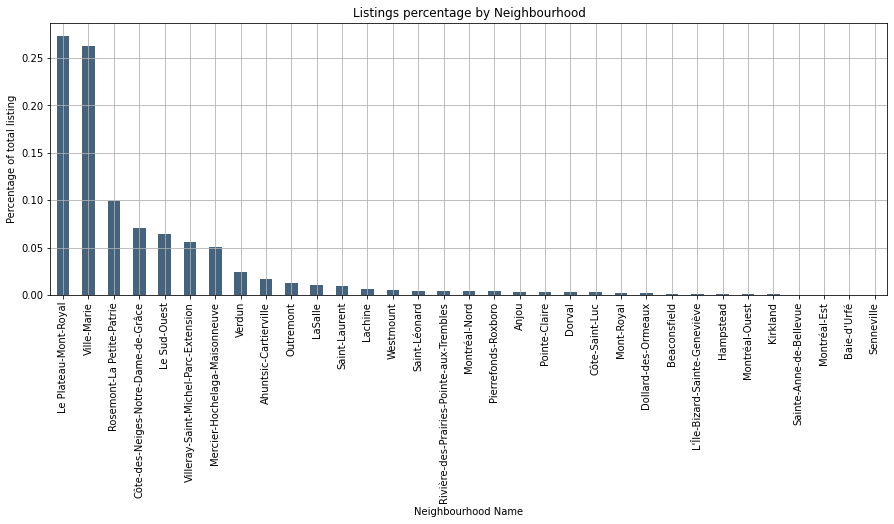

In [290]:
# Get listings by neighbourhood
cat_nhood = df['neighbourhood_cleansed'].value_counts()
cat_nhood_perc = cat_nhood/df.shape[0]

cat_nhood_plot = cat_nhood_perc.plot(kind="bar",figsize=(15,5),grid=True,
                                            color='#46637D',
                                           title ="Listings percentage by Neighbourhood");
cat_nhood_plot.set_xlabel('Neighbourhood Name')
cat_nhood_plot.set_ylabel('Percentage of total listing')

We can see from the daigram above that 2 neighbourhoods account for more than 50% of the listings in Montréal. These 2 are central areas that are well serviced by public transportation. 
We can better visualize percentage with a pie chart. We can do some bundling of neighbhourhoods as 'other'.

In [235]:
# do a Pie chart with anything less than 0.005% listing considered as 'other'.


## Listings by Room Type

In [253]:
# Check for missing data. If answer is 1.0, there is no missing data.
df['room_type'].count()/len(df['room_type'])


1.0

In [254]:
room_type = df['room_type'].value_counts()
room_type

Entire home/apt    14311
Private room        5604
Shared room          201
Hotel room            60
Name: room_type, dtype: int64

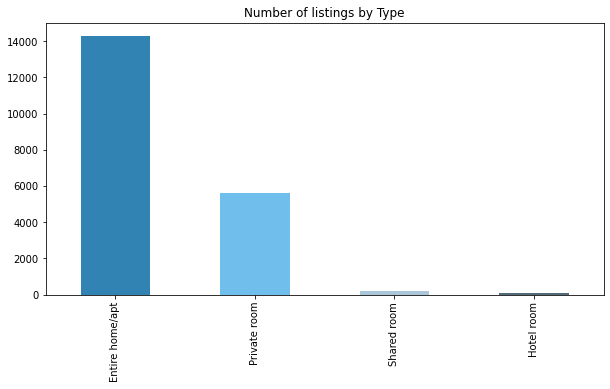

In [291]:
room_type_plot = listings_by_neigh.plot(kind="bar",figsize=(10,5),
                                            color=['#3083B3','#70BEEB','#A9C7D9','#526B7A'], title ="Number of listings by Type"
)

Text(0, 0.5, 'Room Type')

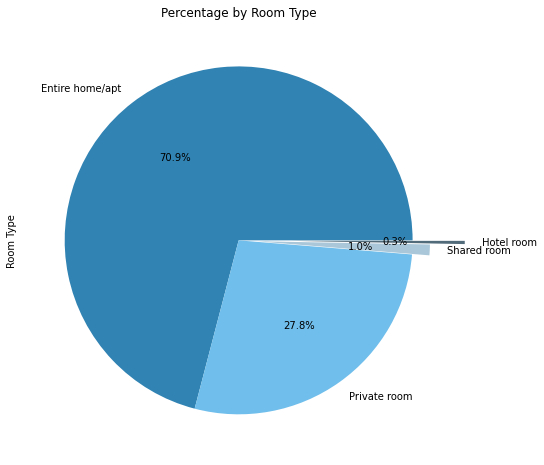

In [289]:
room_type_perc = room_type/df.shape[0]
room_type_pie = room_type_perc.plot.pie(figsize=(8,8),autopct='%1.1f%%',
                                        explode=(0, 0, 0.1,0.3),colors = ['#3083B3','#70BEEB','#A9C7D9','#526B7A'],
                                        title='Percentage by Room Type'
                                       )
room_type_pie.set_ylabel('Room Type')
